## Imports Necessários

In [1]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from sklearn.metrics import mean_squared_error

import xgboost as xgb
from xgboost import XGBRegressor

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

pd.set_option('display.max_rows', None)


In [2]:
df = pd.read_csv('C:\\Users\\marce\\OneDrive\\Dokumenti\\GitHub\\psValcann\\Valcann-Ps\\data\\vendas_produto_alfa.csv')

In [3]:
df.head()

,data,vendas,dia_da_semana,em_promocao,feriado_nacional
0,2025-08-08 22:01:44.459032,139.0,sexta-feira,False,False
1,2025-07-04 22:01:44.459032,133.0,sexta-feira,True,True
2,2024-12-25 22:01:44.459032,579.0,quarta-feira,True,False
3,2025-04-14 22:01:44.459032,105.0,segunda-feira,False,False
4,2026-03-25 22:01:44.459032,60.0,quarta-feira,True,False


## Exploratory Data Analysis

In [4]:
df.shape

(1015, 5)

In [5]:
df.dtypes

data                 object
vendas              float64
dia_da_semana        object
em_promocao          object
feriado_nacional     object
dtype: object

In [6]:
df.isnull().sum()

data                10
vendas              59
dia_da_semana       40
em_promocao         30
feriado_nacional    10
dtype: int64

### NULL Values

In [7]:
# Data
df = df.loc[~df['data'].isna()]

In [8]:
df['data'] = pd.to_datetime(df['data'])

In [9]:
# Vendas
df['vendas'] = df['vendas'].fillna(
    df.groupby('dia_da_semana')['vendas'].transform('mean')
)

In [10]:
# Dia da Semana

dias_semana = {
    0: 'segunda-feira',
    1: 'terca-feira',
    2: 'quarta-feira',
    3: 'quinta-feira',
    4: 'sexta-feira',
    5: 'sabado',
    6: 'domingo'
}

def preencher_dia_da_semana(row):
    if pd.isna(row['dia_da_semana']):
        return dias_semana[row['data'].weekday()]
    else:
        return row['dia_da_semana']

df['dia_da_semana'] = df.apply(preencher_dia_da_semana, axis=1)


In [11]:
# Em Promoção
probs = df['em_promocao'].value_counts(normalize=True)

# Função para imputar nulos
def imputar_em_promocao(val):
    if pd.isna(val):
        return np.random.choice([True, False], p=[probs[True], probs[False]])
    else:
        return val

df['em_promocao'] = df['em_promocao'].apply(imputar_em_promocao)


### Transformation

In [12]:
# Vendas -> INT
df['vendas'] = df['vendas'].astype(int)

# Em Promocao -> False 0 | True 1
df['em_promocao'] = df['em_promocao'].astype(int)

# Feriado Nacional -> False 0 | True 1
df['feriado_nacional'] = df['feriado_nacional'].astype(int)

# Dias da Semana
dias_semana = {
    'segunda-feira': 0,
    'terca-feira': 1,
    'quarta-feira': 2,
    'quinta-feira': 3,
    'sexta-feira': 4,
    'sabado': 5,
    'domingo': 6
}

def transformar_dias(col):
    return col.map(dias_semana)

df['dia_da_semana'] = transformar_dias(df['dia_da_semana'])

df['dia_da_semana'] = df['dia_da_semana'].astype(int)


### Univariate Analysis

In [13]:
df['vendas'].describe()

count    1005.000000
mean      129.419900
std        62.366757
min       -66.000000
25%        90.000000
50%       130.000000
75%       164.000000
max       873.000000
Name: vendas, dtype: float64

#### Histograma

<Axes: xlabel='vendas', ylabel='Count'>

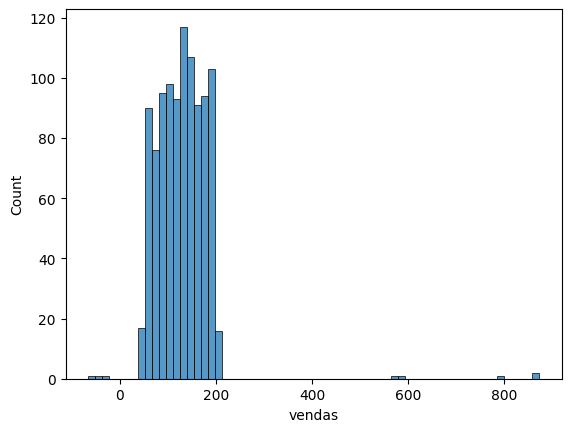

In [14]:
sns.histplot(data=df, x="vendas")

#### Boxplot

<Axes: xlabel='vendas'>

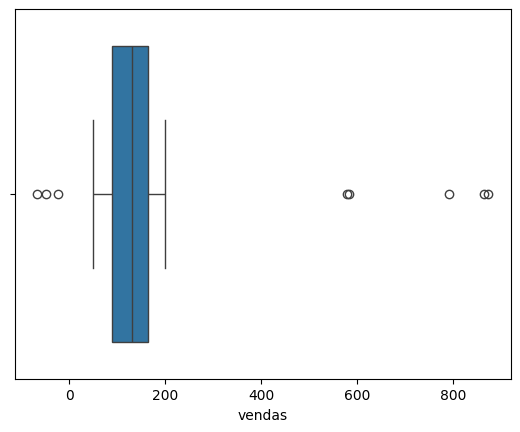

In [15]:
sns.boxplot(data=df, x="vendas")

### Multivariate Analysis

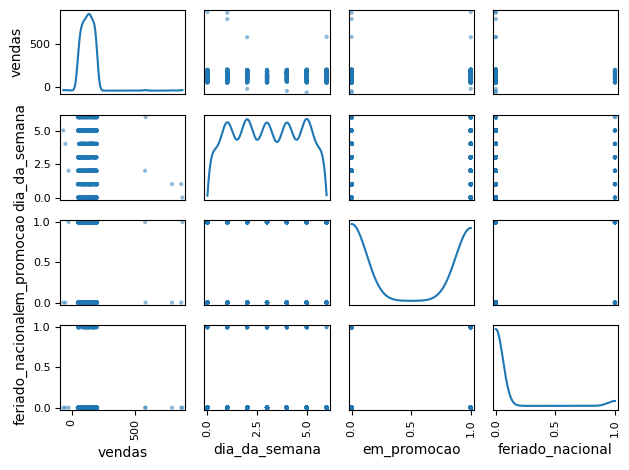

In [16]:
scatter_matrix(df, diagonal="kde")
plt.tight_layout()
plt.show()


## Pre Processing / Normalization

In [17]:
df.drop_duplicates(inplace=True)

## Feature Engineering

In [18]:
# Mês
df['Mês'] = df['data'].dt.month

# Final de Semana
df['Fds'] = (df['dia_da_semana'] >= 5).astype(int)

# Dia de Semana
df['Dia de Semana'] = (df['dia_da_semana'] <= 4).astype(int)

### Train / Test

In [19]:
# Ordenar por data, caso não esteja
df = df.sort_values('data')

# Definir o tamanho da amostra de teste (14 dias)
test_size = 14

# Separar treino e teste
train_df = df.iloc[:-test_size]
test_df = df.iloc[-test_size:]


In [20]:
from scipy.stats import ttest_ind

vendas_promocao = df[df['em_promocao'] == 1]['vendas']
vendas_sem_promocao = df[df['em_promocao'] == 0]['vendas']

t_stat, p_val = ttest_ind(vendas_promocao, vendas_sem_promocao, equal_var=False)

print(f"t = {t_stat:.4f}, p = {p_val:.4f}")


t = 0.4050, p = 0.6855


In [21]:
vendas_fds = df[df['Fds'] == 1]['vendas']
vendas_dias_uteis = df[df['Fds'] == 0]['vendas']

t_stat, p_val = ttest_ind(vendas_fds, vendas_dias_uteis, equal_var=False)

print(f"t = {t_stat:.4f}, p = {p_val:.4f}")

t = -0.2285, p = 0.8193


## Model 

In [23]:


features = ['dia_da_semana', 'em_promocao', 'feriado_nacional', 'Fds'] 
target = 'vendas'

X_train = train_df[features]
y_train = train_df[target]

X_test = test_df[features]
y_test = test_df[target]

model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=200,
    random_state=42,
    learning_rate=0.01,
    max_depth=7,
    subsample=0.7,
    colsample_bytree=0.7
)


model.fit(X_train, y_train)


y_pred = model.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'RMSE no teste: {rmse:.2f}')



RMSE no teste: 36.36


In [24]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 1],
    'colsample_bytree': [0.7, 1]
}

xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

grid_search = GridSearchCV(estimator=xgb_reg, param_grid=param_grid,
                           scoring='neg_root_mean_squared_error', cv=3, verbose=1)

grid_search.fit(X_train, y_train)

print("Melhores parâmetros:", grid_search.best_params_)
print("Melhor RMSE:", -grid_search.best_score_)


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Melhores parâmetros: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.7}
Melhor RMSE: 62.02307001749674


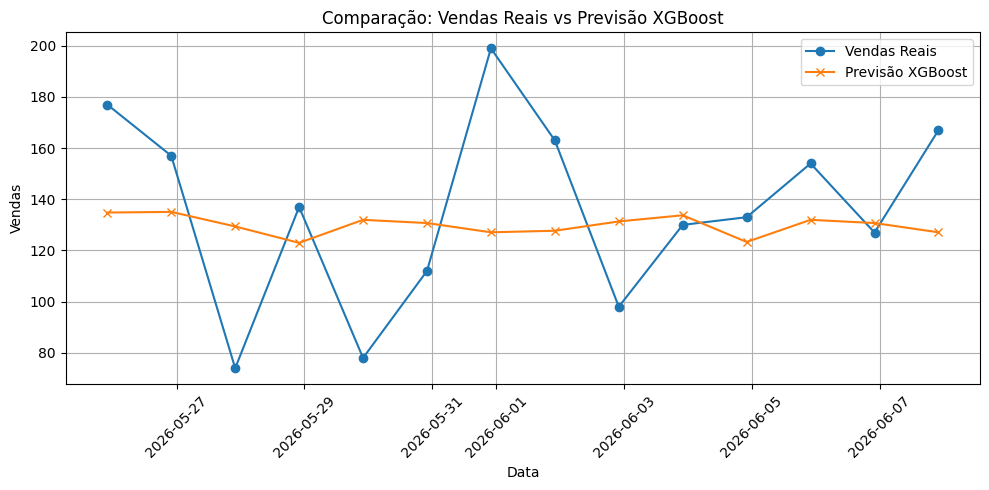

In [25]:
plt.figure(figsize=(10,5))
plt.plot(test_df['data'], test_df['vendas'], label='Vendas Reais', marker='o')
plt.plot(test_df['data'], y_pred, label='Previsão XGBoost', marker='x')
plt.xlabel('Data')
plt.ylabel('Vendas')
plt.title('Comparação: Vendas Reais vs Previsão XGBoost')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Linear Regression

In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Separar features e target
features = ['dia_da_semana', 'em_promocao', 'feriado_nacional', 'Fds', 'Dia de Semana']
target = 'vendas'

X_train = train_df[features]
y_train = train_df[target]

X_test = test_df[features]
y_test = test_df[target]

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
print(f'RMSE Regressão Linear no teste: {rmse_lr:.2f}')

RMSE Regressão Linear no teste: 35.72


Um treinamento muito rápido me indica que usando um algoritmo de regressao linear, eu tenho um erro quadrado médio, menor que o xgboost, então vamos optar por usar ele mesmo. 